In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download kay_labels.npy completed!
Download kay_labels_val.npy completed!
Download kay_images.npz completed!


In [4]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [91]:
print(labels[:, :4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [92]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [7]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [8]:
print(dat["responses"].shape)

(1750, 8428)


This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [9]:
dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

{'Other': 0,
 'V1': 1294,
 'V2': 2083,
 'V3': 1790,
 'V3A': 484,
 'V3B': 314,
 'V4': 1535,
 'LatOcc': 928}

Each stimulus is a 128 x 128 grayscale array:

C:\Users\simon\AppData\Local\Temp\ipykernel_16688\24014900.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


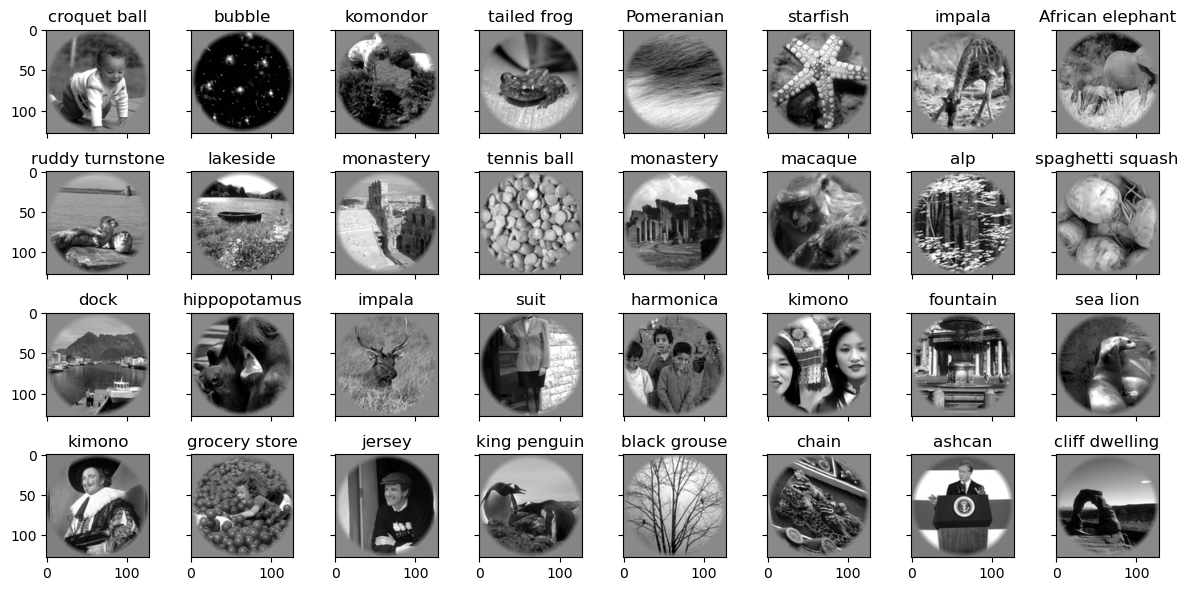

In [45]:
fig, axs = plt.subplots(4, 8, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1, :]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

C:\Users\simon\AppData\Local\Temp\ipykernel_16688\2625672689.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


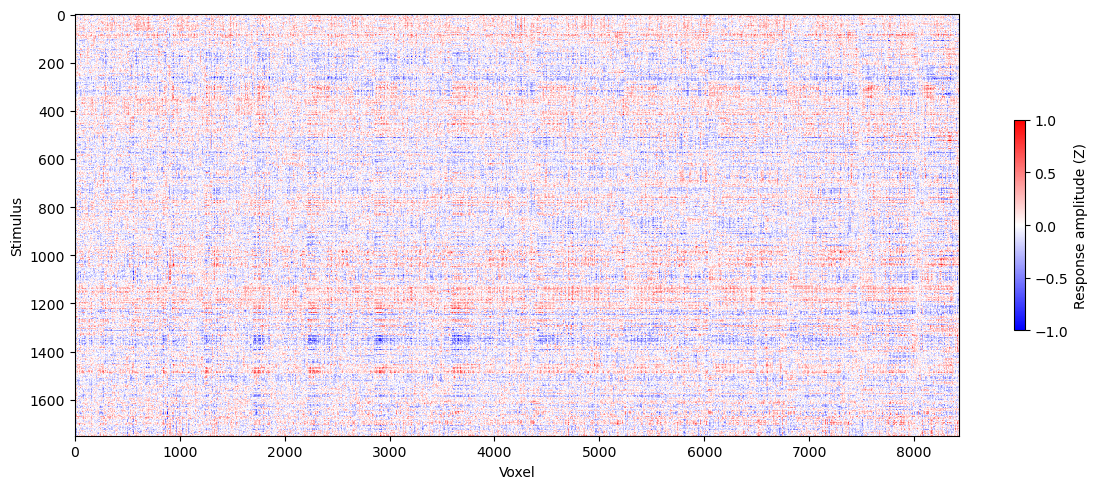

In [90]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_16688\1498469230.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


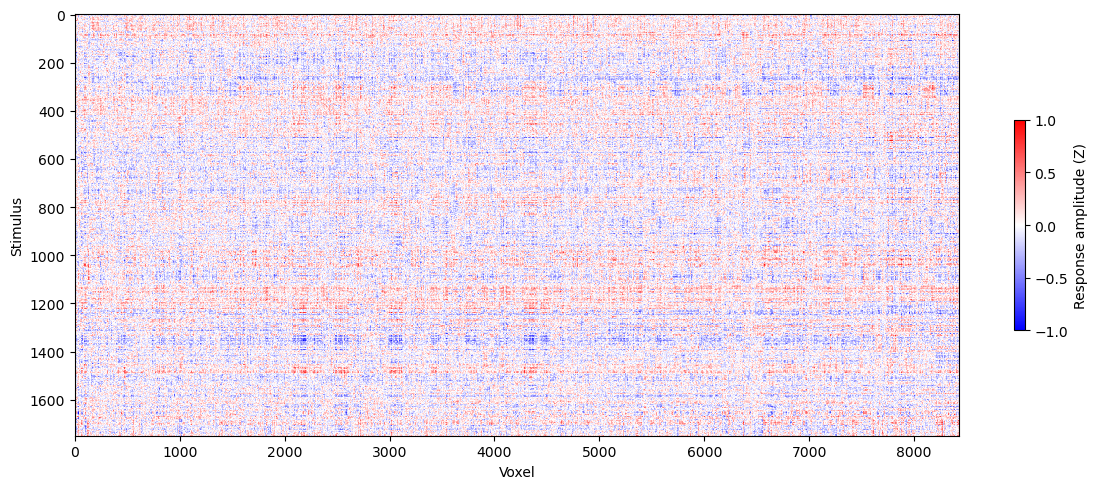

In [109]:
# Sort dat['roi'] ascending and use this order to sort dat['responses']
roi_order = np.argsort(dat['roi'])
sorted_roi = dat['roi'][roi_order]
sorted_responses = dat['responses'][:, roi_order]

# Plot the sorted responses
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(sorted_responses,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [152]:
# Split dat['responses'] by their corresponding category in labels

# Get the unique categories in labels
categories = np.unique(labels[0, :])
print("Unique categories:", categories)

# Split the responses by category (each category should have shape (num_img, 8428))
responses_by_category = [dat['responses'][labels[0, :] == category, :] for category in categories]

# Print shapes of responses_by_category
for category, category_responses in zip(categories, responses_by_category):
  print(f"Category {category} has shape {category_responses.shape}")

Unique categories: ['animal' 'artifact' 'entity' 'fruit' 'fungus' 'geological formation'
 'person' 'plant']
Category animal has shape (589, 8428)
Category artifact has shape (812, 8428)
Category entity has shape (72, 8428)
Category fruit has shape (77, 8428)
Category fungus has shape (5, 8428)
Category geological formation has shape (192, 8428)
Category person has shape (2, 8428)
Category plant has shape (1, 8428)


C:\Users\simon\AppData\Local\Temp\ipykernel_16688\1454581728.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


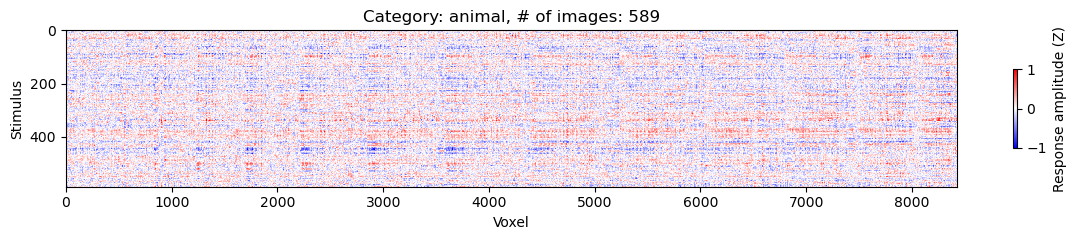

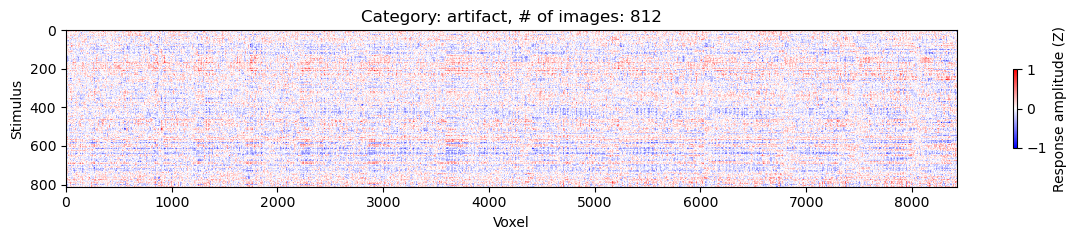

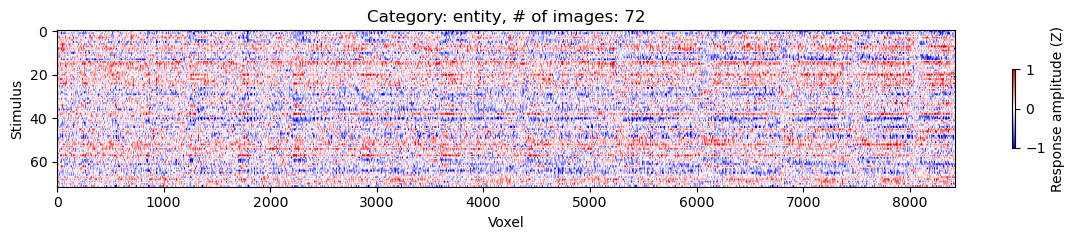

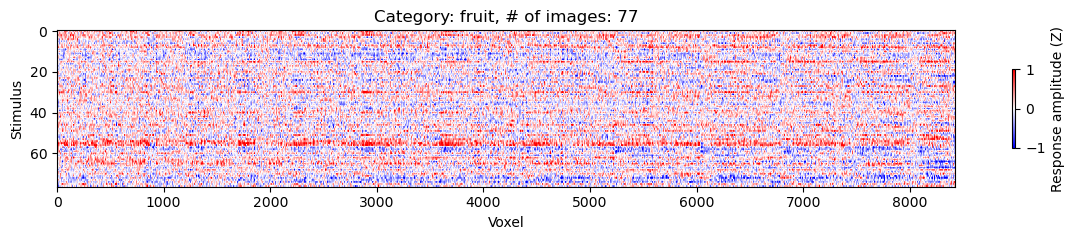

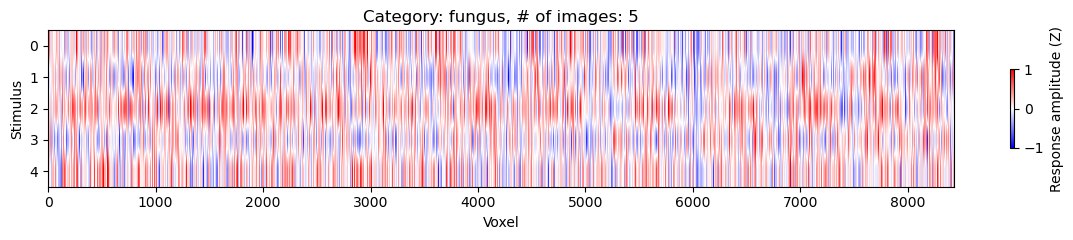

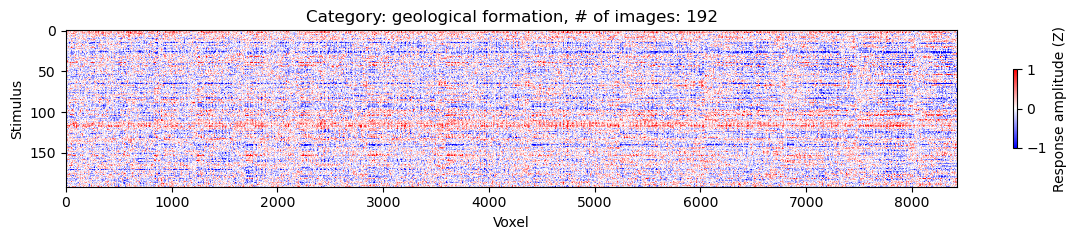

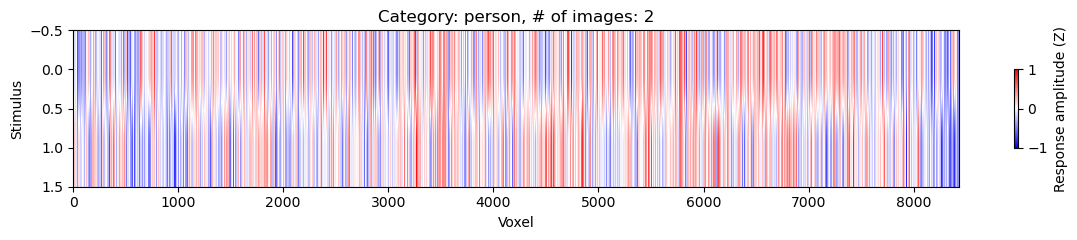

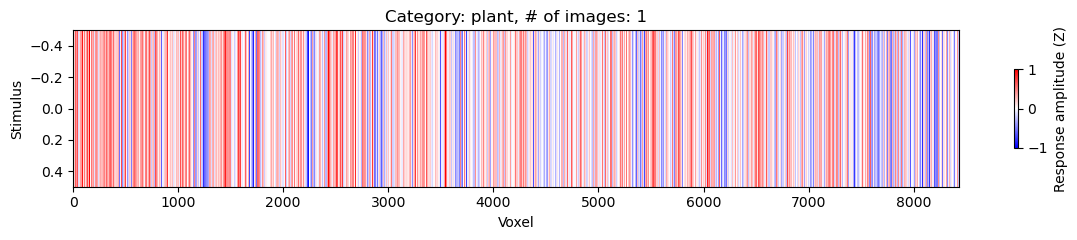

In [166]:
# Plot the responses for each category
for i in range(len(categories)):
    fig, ax = plt.subplots(figsize=(12, 2.5))
    ax.set_title(f"Category: {categories[i]}, # of images: {responses_by_category[i].shape[0]}")
    ax.set(xlabel="Voxel", ylabel="Stimulus")
    heatmap = ax.imshow(responses_by_category[i],
                        aspect="auto", vmin=-1, vmax=1, cmap="bwr")
    fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    fig.tight_layout()
    fig.show()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

In [ ]:
# Visualize fMRI on brain map


C:\Users\simon\AppData\Local\Temp\ipykernel_16688\3850067406.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


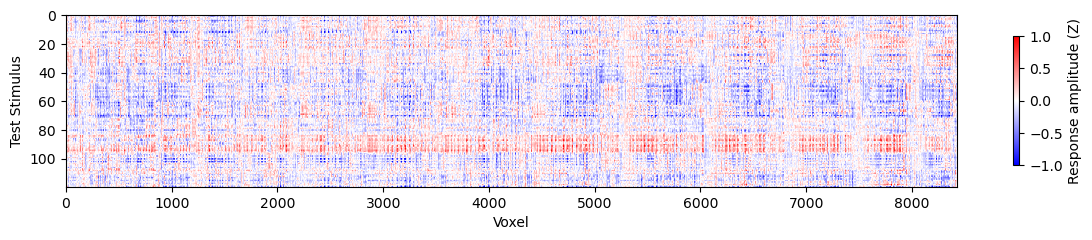

In [12]:
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()